In [1]:
%pylab inline
import scipy.linalg as scila
from numpy.random import default_rng
rng = default_rng()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
paulis = {}
paulis['X'] = np.array([[0,1],[1,0]],dtype=complex)
paulis['Y'] = np.array([[0,-1.j],[1.j,0]],dtype=complex)
paulis['Z'] = np.array([[1,0],[0,-1]],dtype=complex)
paulis['I'] = np.array([[1,0],[0,1]],dtype=complex)

def many_kron(ops):
    # Takes an array of Pauli characters and produces the tensor product
    op = paulis[ops[0]]
    if len(ops) == 1:
        return op

    for opj in ops[1:]:
        op = np.kron(op,paulis[opj])

    return op

In [3]:
def pretty_print(vec):
    nbits = int(log2(len(vec)))
    
    formatstr = "{0:>0" + str(nbits) + "b}"
    
    ix=-1
    for x in vec:
        ix += 1
        if abs(x) < 1e-8:
            continue
        
        print(formatstr.format(ix),": ",x)
    
#pretty_print([0.5,0.2,0,0.1])

In [4]:
def heisenberg_ham(N,Jx=-1,Jy=-1,Jz=-1,hz=1e-5):
    
    ham = np.zeros([2**N,2**N],dtype=complex)
    
    base_string = ['I']*N
    
    hamterms = []
    
    for i in range(N):
        
        if abs(hz) > 1e-8:
            ss = copy(base_string)
            ss[i] = 'Z'
            ham += hz*many_kron(ss)        
            hamterms.append(("".join(ss),hz,many_kron(ss)))
        
        j = mod(i+1,N)
            
        if abs(Jx) > 1e-8:
            ss = copy(base_string)
            ss[i] = 'X'
            ss[j] = 'X'
            ham += Jx*many_kron(ss)
            hamterms.append(("".join(ss),Jx,many_kron(ss)))
        
        if abs(Jy) > 1e-8:
            ss = copy(base_string)
            ss[i] = 'Y'
            ss[j] = 'Y'
            ham += Jy*many_kron(ss)
            hamterms.append(("".join(ss),Jy,many_kron(ss)))
        
        if abs(Jz) > 1e-8:
            ss = copy(base_string)
            ss[i] = 'Z'
            ss[j] = 'Z'
            ham += Jz*many_kron(ss)
            hamterms.append(("".join(ss),Jz,many_kron(ss)))
    
    return ham,hamterms

In [5]:
hammat, hamterms = heisenberg_ham(N=4,Jx=-1,Jy=-1,Jz=-1,hz=1e-9)
evals, evecs = eigh(hammat)
print(evals)
pretty_print(evecs[:,0])
pretty_print(evecs[:,4])

[-4.00000000e+00 -4.00000000e+00 -4.00000000e+00 -4.00000000e+00
 -4.00000000e+00 -9.02056208e-17 -9.86557441e-32 -2.76747243e-32
  0.00000000e+00  5.25869973e-47  4.00488069e-32  7.14552749e-17
  4.00000000e+00  4.00000000e+00  4.00000000e+00  8.00000000e+00]
0000 :  (1+0j)
0111 :  (0.5000000000000001+0j)
1011 :  (0.49999999999999994+0j)
1101 :  (0.5000000000000001+0j)
1110 :  (0.5+0j)


In [6]:
def observable(vec):
    
    Nsites = int(np.log2(len(vec)))
    #print(Nsites)
    base_string = ['I']*Nsites
    base_string[0] = 'Z'
    return conjugate(vec) @ many_kron(base_string) @ vec
    

vec0 = np.zeros(2**4,dtype=complex)
vec0[1] = 0.5
print(observable(vec0))


(0.25+0j)


# DEFINE YOUR PROBLEM HERE ########

In [38]:
# DEFINE YOUR PROBLEM HERE ########

N = 6
hammat, hamterms = heisenberg_ham(N=N,Jx=-1,Jy=-1,Jz=0.1,hz=0)


# Stuff for qdrift
qdrift = {}
qdrift["lam"] = 0
qdrift["probs"] = []
Lam = -99
for term in hamterms:
    qdrift["lam"] += abs(term[1])
    if abs(term[1]) > Lam:
        Lam = abs(term[1])

for term in hamterms:
    qdrift["probs"].append(abs(term[1])/qdrift["lam"])
    #print(term[0],qdrift["probs"][-1])


    

###################################

XXIIII 814
YYIIII 805
ZZIIII 73
IXXIII 824
IYYIII 770
IZZIII 77
IIXXII 771
IIYYII 759
IIZZII 89
IIIXXI 793
IIIYYI 801
IIIZZI 78
IIIIXX 809
IIIIYY 791
IIIIZZ 82
XIIIIX 774
YIIIIY 817
ZIIIIZ 73


(0.0, 5.0)

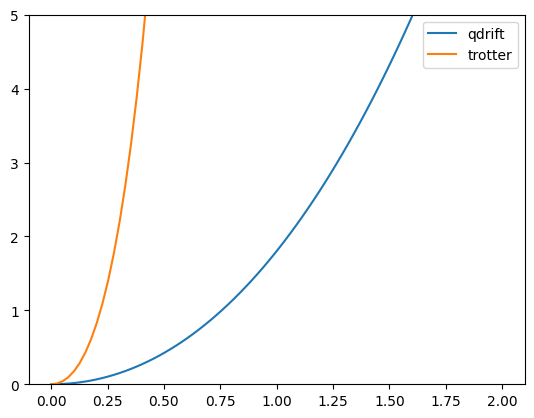

In [39]:
# Test the random number generator and
# make a plot of the expected error scaling

test_probs = rng.choice(len(hamterms),10000,p=qdrift["probs"],shuffle=False)

for it,term in enumerate(hamterms):
    print(term[0],len(where(test_probs==it)[0]))
    
fig, ax = subplots()
tax = linspace(0,2,80)

Ngates = 200

qdrift_errterm = 2*(qdrift["lam"]*tax)**2/(Ngates)**2 
#ax.plot(tax, Ngates*errterm)
ax.plot(tax, Ngates*qdrift_errterm * exp(2*qdrift["lam"]*tax/(Ngates)),label="qdrift")


trotter_errterm = len(hamterms)**2 * Lam**2 * tax**2 / (2*Ngates/len(hamterms)) * exp(Lam * tax * len(hamterms)**2/Ngates)
ax.plot(tax, trotter_errterm,label='trotter')
ax.legend()
ax.set_ylim(0,5)

Budget: 200 gates, which is 11 Trotter steps


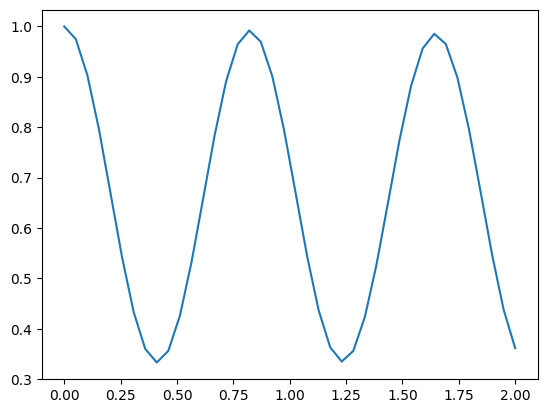

In [40]:
def evolve_trotter(tmax, Ntrot, hammat, hamterms, initial_vec):
    
    tax = np.linspace(0,tmax,Ntrot)
    dt = tax[1]-tax[0]
    
    vec = np.copy(initial_vec)
    for it, t in enumerate(tax):
        vec = scila.expm(-1.j * dt * hammat) @ vec
            
    return observable(vec)


def trotter_sampler(tmin, tmax, Nt, Ngates):
    tax = linspace(tmin, tmax, Nt)
    datas = np.zeros(Nt, dtype=complex)
    
    Ntrot = int(Ngates / len(hamterms))
    print("Budget: {} gates, which is {} Trotter steps".format(Ngates,Ntrot))
    
    for it, t in enumerate(tax):
        vec0 = np.zeros(2**N,dtype=complex)
        vec0[5] = 1.
        datas[it] = evolve_trotter(t,Ntrot,hammat, hamterms, vec0)
        
    fig, ax = subplots()#figsize=(4,4))
    ax.plot(tax, np.real(datas),'-')
    return tax, datas
    


exact = trotter_sampler(tmin=0,tmax=2,Nt=40,Ngates=Ngates)

Budget: 200 gates, which is 11 Trotter steps


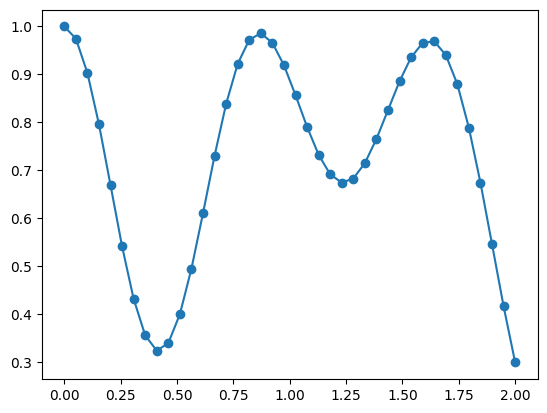

In [41]:
def evolve_qtrotter(tmax, Nsteps, hammat, hamterms, initial_vec):
    
    tax = np.linspace(0,tmax,Nsteps)
    dt = tax[1]-tax[0]
    
    vec = np.copy(initial_vec)
    for it, t in enumerate(tax):
        
        for term in hamterms:
            pstring = term[0]
            coef = term[1]
            pmat = term[2]
            
            vec = scila.expm(-1.j * dt * coef * pmat) @ vec
            #vec /= sqrt(conjugate(vec) @ vec)
            
    return observable(vec)


def qtrotter_sampler(tmin, tmax, Nt, Ngates):
    tax = linspace(tmin, tmax, Nt)
    datas = np.zeros(Nt, dtype=complex)

    Ntrot = int(Ngates / len(hamterms))
    print("Budget: {} gates, which is {} Trotter steps".format(Ngates,Ntrot))

    for it, t in enumerate(tax):
        vec0 = np.zeros(2**N,dtype=complex)
        vec0[5] = 1.
        datas[it] = evolve_qtrotter(t,Ntrot,hammat, hamterms, vec0)
        
    fig, ax = subplots()
    ax.plot(tax, datas,'o-')
    return tax, datas
    

approx = qtrotter_sampler(tmin=0,tmax=2,Nt=40,Ngates=Ngates)

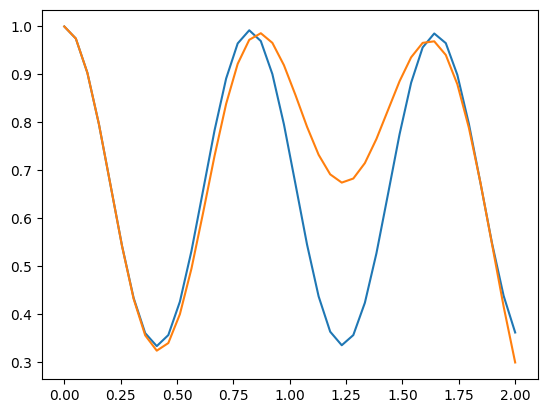

In [42]:
fig, ax = subplots()
ax.plot(exact[0],exact[1])
ax.plot(approx[0],approx[1])

Budget: 1428 gates


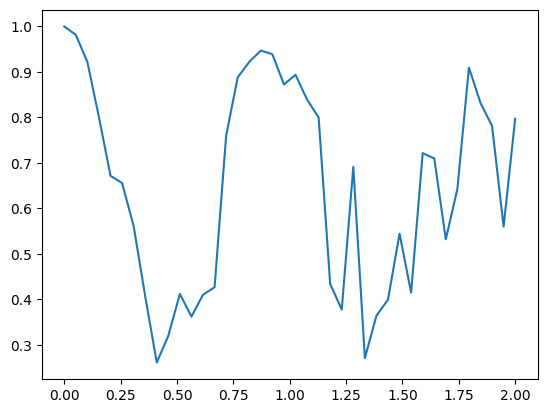

In [43]:
def evolve_rand_qtrotter(t, Ngates, hammat, hamterms, vec):
    

    
    termlist = rng.choice(len(hamterms),Ngates,p=qdrift["probs"],shuffle=True)

    tau = t * qdrift["lam"] / Ngates

    for i in termlist:
        pmat = hamterms[i][2]
        vec = scila.expm(-1.j * tau * pmat) @ vec
        
    return observable(vec)
    

    
def rand_qtrotter_sampler(tmin, tmax, Nt, Ngates, verbose=False):
    tax = linspace(tmin, tmax, Nt)
    datas = np.zeros(Nt, dtype=complex)
    
    if verbose:
        print("Budget: {} gates".format(Ngates))
    
    for it, t in enumerate(tax):
        vec0 = np.zeros(2**N,dtype=complex)
        vec0[5] = 1.
        datas[it] = evolve_rand_qtrotter(t, Ngates, hammat, hamterms, vec0)
        
    if verbose:
        fig, ax = subplots()
        ax.plot(tax, datas)
    
    return tax, datas    
    
rand_qtrotter_sampler(tmin=0,tmax=2,Nt=40,Ngates=Ngates,verbose=True);

1 out of 20
11 out of 20


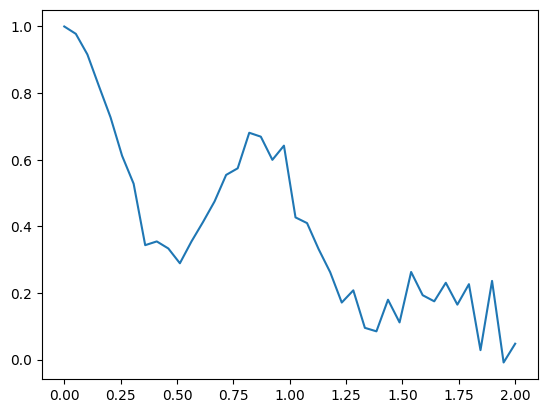

In [47]:
def random_sampler(Nsamples,tmin,tmax,Nt,Ngates):
    
    yvals = np.zeros([Nt,Nsamples],dtype=complex)
    for ix in range(Nsamples):
        if mod(ix,10) == 0:
            print("{} out of {}".format(ix+1,Nsamples))
        data = rand_qtrotter_sampler(tmin=tmin,tmax=tmax,Nt=Nt,Ngates=Ngates)
        yvals[:,ix] = data[1]
        
        
    tax = linspace(tmin, tmax, Nt)
    fig, ax = subplots()
    ax.plot(tax, average(yvals,axis=1))
    
    return tax, yvals

qdrift_data = random_sampler(Nsamples=20,tmin=0,tmax=2,Nt=40,Ngates=Ngates)

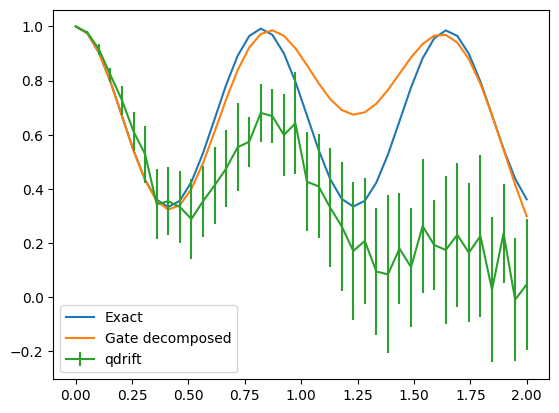

In [48]:

fig, ax = subplots()
ax.plot(exact[0],exact[1],label='Exact')
ax.plot(approx[0],approx[1],label='Gate decomposed')
ax.errorbar(qdrift_data[0],average(qdrift_data[1],axis=1),yerr=std(qdrift_data[1],axis=1)/sqrt(len(qdrift_data)),label='qdrift')
ax.legend()

